![alt text](https://i.imgur.com/1WaY7aA.png)

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
train_data = '../Data/titanic_train.csv'
#test_data = 'Data/titanic_test.csv'

data = pd.read_csv(train_data, index_col='PassengerId')
#test = pd.read_csv(test_data)
titanic = data.copy(deep=True)

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [3]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
# Age, Cabin and Embarked have missing values

def alternate_missing_age(data):
    # Calulate the average age of children and adults independantly taking into account the differences in sex
    master_age = data['Age'][(data['Age'] <= 16) & (data['Sex'] == 'male')].mean()
    miss_age = data['Age'][(data['Age'] <= 16) & (data['Sex'] == 'female')].mean()
    mister_age = data['Age'][(data['Age'] > 16) & (data['Sex'] == 'male')].mean()
    misses_age = data['Age'][(data['Age'] > 16) & (data['Sex'] == 'female')].mean()

    # I will assume the 1 row with Dr, is a male, considering the era.
    miss_mask = (data['Age'].isnull() == True) & (data['Name'].str.contains('Miss') == True)
    master_mask = (data['Age'].isnull() == True) & (data['Name'].str.contains('Master') == True)
    misses_mask = (data['Age'].isnull() == True) & (data['Name'].str.contains('Mrs') == True)
    mister_mask = (data['Age'].isnull() == True) & (data['Name'].str.contains('Mr') == True) | \
                (data['Name'].str.contains('Dr') == True)

    data['Age'][miss_mask] = miss_age
    data['Age'][master_mask] = master_age
    data['Age'][misses_mask] = misses_age
    data['Age'][mister_mask] = mister_age

    return data

data = alternate_missing_age(data)

In [6]:
if (data['Cabin'].isnull().sum()/data.shape[0]) > 0.6:
    print ('There is more than 60% of the data missing, drop the Cabin feature')
    
else:
    print ('There is sufficient data to try to impute the missing values')


There is more than 60% of the data missing, drop the Cabin feature


In [7]:
data.drop(['Cabin'],axis=1,inplace=True)

In [8]:
# Most people got on at Southampton
data['Embarked'][data['Embarked'].isnull() == True] = data['Embarked'].mode()[0]

In [9]:
def bar_chart(train, feature):
    survived = train[train['Survived']==1][feature].value_counts(normalize=True)*100
    died = train[train['Survived']==0][feature].value_counts(normalize=True)*100
    df = pd.DataFrame([survived,died])
    df.index = ['Survived','Died']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

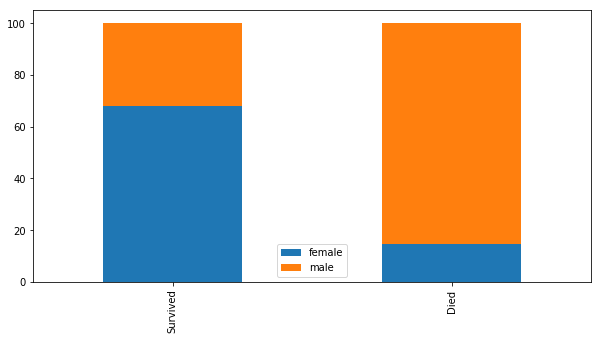

In [10]:
bar_chart(data, 'Sex')

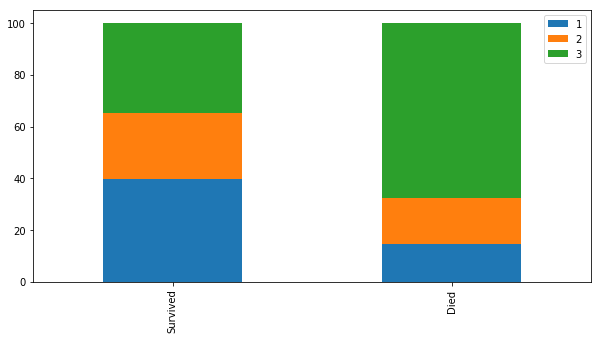

In [11]:
bar_chart(data, 'Pclass')

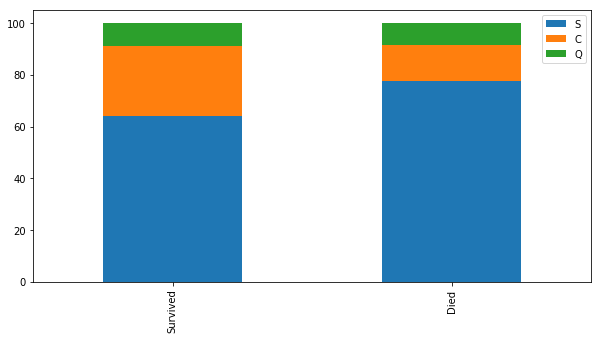

In [12]:
bar_chart(data, 'Embarked')

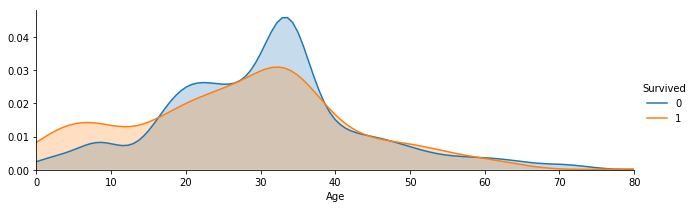

In [13]:
def facetgrid_survived(data,feature):
    facet = sns.FacetGrid(data, hue="Survived", aspect=3)
    facet.map(sns.kdeplot, feature, shade= True)
    facet.set(xlim=(0, data[feature].max()))
    facet.add_legend()
    plt.show();
    
facetgrid_survived(data,'Age')

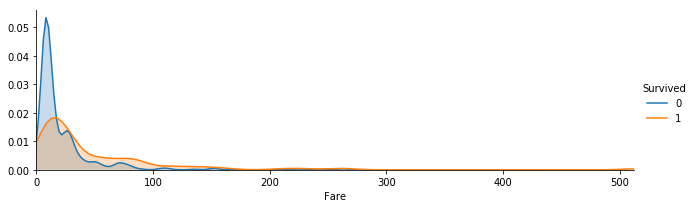

In [14]:
facetgrid_survived(data,'Fare')

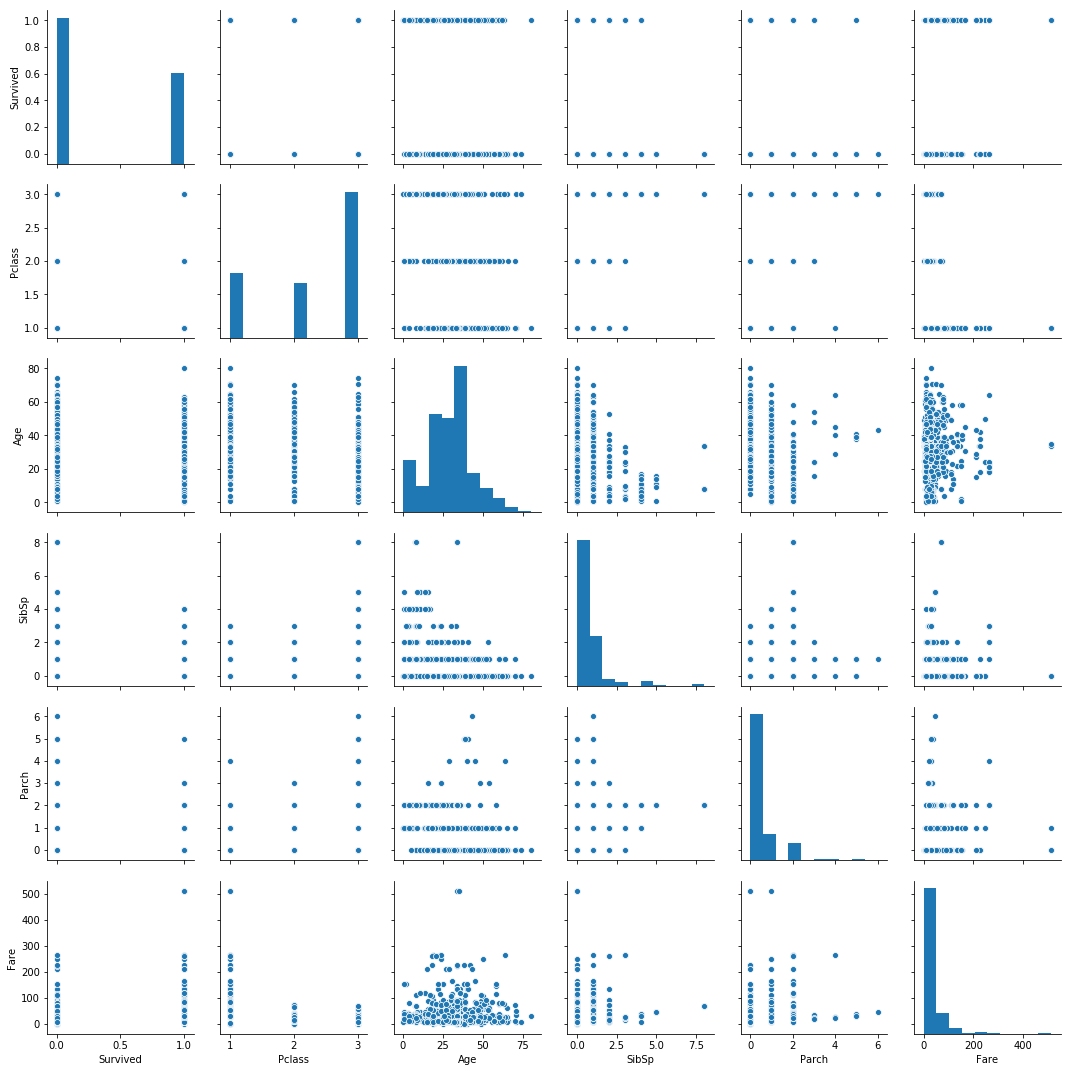

In [15]:
numeric_data = data.select_dtypes(include=[np.number])
sns.pairplot(numeric_data);
plt.show()

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [16]:
# ANSWER
feature_cols = ['Pclass','Parch']
X = data[feature_cols]
y = data['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [17]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [18]:
# ANSWER
# Create Model
model = LogisticRegression()


Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [19]:
# ANSWER
# Fit Model
fit = model.fit(X_train, y_train)

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [20]:
# ANSWER
model.coef_

array([[-0.88004686,  0.33746428]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [21]:
# ANSWER
model.intercept_

array([1.33560599])

We can create tuples of the predictor names and coefficients like this:

In [22]:
# ANSWER
print(set(zip(feature_cols, model.coef_[0])))

{('Pclass', -0.8800468638257546), ('Parch', 0.33746427592522643)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [23]:
for col in zip(X_train.columns, model.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.880047
Parch       +0.337464


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [24]:
# ANSWER
model.score(X_train, y_train)

0.6924157303370787

What is the  `accuracy_score` for the test data?

In [25]:
# ANSWER
model.score(X_test, y_test)

0.6536312849162011

What can we say aout this result?

ANSWER
- When using the `Pclass` and `Parch` features, we can reasonably predict the correct value for `Survived` 65% of the time 
- There is a slightly higher success rate for data that has already been seen.

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [26]:
# ANSWER
feature_cols.append('Age')

data['Age'][data['Age'].isnull() == True] = data['Age'].mean()
#train = alternate_missing_age(train)

In [27]:
# Build Model
model = LogisticRegression()
# Fit Model
fit = model.fit(X_train, y_train)
# Score
model.score(X_test, y_test)

0.6536312849162011

So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- `Age` has no correlation to whether a person survived.
- It seems that the notion of *"Women and children first"* doesn't apply in the moment.

Let's see where the model is going wrong by showing the Confusion Matrix:

In [28]:
# ANSWER
y_pred_class = model.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[87 19]
 [43 30]]


Nb. Here is how `confusion_matrix` arranges its output:

In [29]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: 
False Negative

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

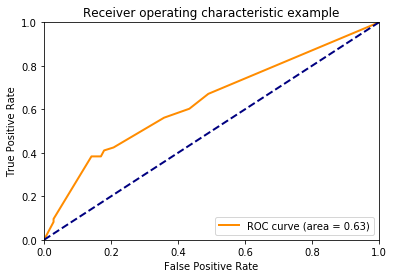

In [30]:
# Generate the prediction values for each of the test observations using predict_proba()
# function rather than just predict
def plot_roc(model, X_test, y_test):
    preds = model.predict_proba(X_test)[:,1]

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    # Store the Area Under the Curve (AUC) so we can annotate our graph with these metric
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()
    
plot_roc(model, X_test, y_test)

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [31]:
titanic_with_dummies = pd.get_dummies(data = titanic, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [32]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [33]:
# ANSWER
# Set Feature Both Numerical, Categorical
feature_cols = ['Parch','Age',
                'Sex_female','Sex_male',
                'Embarked_C','Embarked_Q','Embarked_S',
                'Pclass_1','Pclass_2','Pclass_3']

X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [34]:
# Build Model
model = LogisticRegression()
# Fit Model
fit = model.fit(X_train, y_train)
# Score
model.score(X_test, y_test)

0.7821229050279329

Plot the ROC curve for the new model:

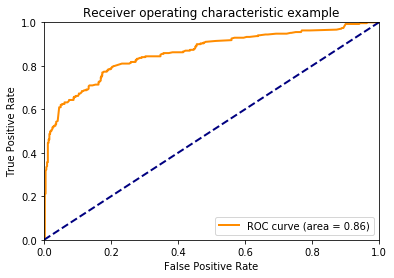

In [35]:
# ANSWER
plot_roc(model, X_train, y_train)

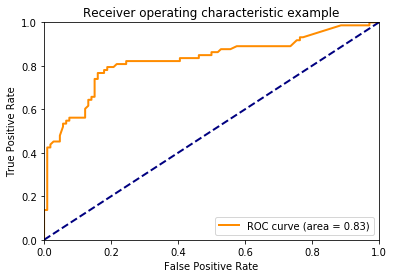

In [36]:
plot_roc(model, X_test, y_test)

Did we improve the model by including the remaining features?

**Answer:** Yes, we increase the ROC curve by 20% more area.

### 5. Demographics of Survival
#### 5.1 Actual survival:

In [37]:
ttwd = titanic_with_dummies
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
                                            100 * ttwd[ttwd.Sex_male == 1].Survived.mean(), ttwd.Sex_male.sum(), 
                                            100 * ttwd[ttwd.Sex_female == 1].Survived.mean(), ttwd.Sex_female.sum(),
                                            100 * ttwd[ttwd.Age < 16].Survived.mean(), len(ttwd[ttwd.Age < 16])))

Male survival: 18.89% of 577
Female survival: 74.20% of 314
Child survival: 51.96% of 102


#### 5.2 Predicted survival:

In [38]:
# Make a data frame of results, including actual and predicted response:
y_hat = model.predict(X)
y_hats = pd.Series(y_hat, index = X.index)
y_hatdf = pd.DataFrame({'y_hat': y_hats})
y_actuals = pd.Series(y, index = X.index)    # names 'y', 'y_test' are in use
y_actualdf = pd.DataFrame({'y_actual': y_actuals})   
ttall = y_hatdf.join(y_actualdf).join(X)
ttall.head()

,y_hat,y_actual,Parch,Age,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,
1,0,0,0,22.0,0,1,0,0,1,0,0,1
2,1,1,0,38.0,1,0,1,0,0,1,0,0
3,1,1,0,26.0,1,0,0,0,1,0,0,1
4,1,1,0,35.0,1,0,0,0,1,1,0,0
5,0,0,0,35.0,0,1,0,0,1,0,0,1


In [39]:
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
                                                    100 * ttall[ttall.Sex_male == 1].y_hat.mean(), ttall.Sex_male.sum(), 
                                                    100 * ttall[ttall.Sex_female == 1].y_hat.mean(), ttall.Sex_female.sum(),
                                                    100 * ttall[ttall.Age < 16].y_hat.mean(), len(ttall[ttall.Age < 16])))

Male survival:  4.33% of 577
Female survival: 90.13% of 314
Child survival: 56.86% of 102


So, for some reason, this model substantially under-predicts male survival and over-predicts female survival, but does quite well on child survival.

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

### 1. Do the results change with a random choice of splitting

In [40]:
feature_cols = ['Parch','Age',
                'Sex_female','Sex_male',
                'Embarked_C','Embarked_Q','Embarked_S',
                'Pclass_1','Pclass_2','Pclass_3']

X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies['Survived']

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    # Build Model
    model = LogisticRegression()
    # Fit Model
    fit = model.fit(X_train, y_train)
    # Score
    print ('{0}: score: {1}'.format(i+1,model.score(X_test, y_test)))
    

1: score: 0.8212290502793296
2: score: 0.7486033519553073
3: score: 0.776536312849162
4: score: 0.776536312849162
5: score: 0.770949720670391
6: score: 0.7821229050279329
7: score: 0.7318435754189944
8: score: 0.7932960893854749
9: score: 0.770949720670391
10: score: 0.7821229050279329


The score changes by around 8% with randomly chosen splitting.

### 2 Does the accuracy improve with Cross-Validation

In [41]:


feature_cols = ['Parch','Age',
                'Sex_female','Sex_male',
                'Embarked_C','Embarked_Q','Embarked_S',
                'Pclass_1','Pclass_2','Pclass_3']

X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies['Survived']
model = LogisticRegressionCV()
scores = cross_val_score(model, X, y, cv=5)
scores.mean()

0.7912536301500788

There doesn't seem to be a significant change in accuracy.

### 3. Look at the fpr & tpr vectors for the best model.

In [42]:
# Build Model
model = LogisticRegression()

# Fit
model.fit(, y_train)

# Predict
pred = model.predict(X_test)

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, pred)
print(confusion)

#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

SyntaxError: invalid syntax (<ipython-input-42-b353349696af>, line 5)

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, pred)

In [ ]:
fpr

In [ ]:
tpr

In [ ]:
model = LogisticRegressionCV()

# Fit
model.fit(X_train, y_train)

# Predict
pred = model.predict(X_test)

#### Recall
Recall is the number of true positives over all positive values



In [ ]:
recall = TP / (TP + FP)
recall

#### Precision
Precision is the number of true positives over the all positives predictions


In [ ]:
precision = TP / (TP + FN)
precision

In [ ]:
2 * recall * recall/(precision + recall)

**© 2019 Data Science Institute of Australia**